In [65]:
# TODO: consider making list of dependencies for TA to install when running this notebook
import sklearn as sk
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# Import track data
usecols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence']
dataset = pd.read_csv("data.csv", header = 0, usecols=usecols)

# Remove rows duplicated by ignoring some columns
dataset = dataset[~dataset.duplicated()==1]

# Normalize columns having values outside [0, 1]
scaler = MinMaxScaler()
cols_to_normalize = ['duration_ms', 'key', 'loudness', 'popularity', 'tempo']
dataset[cols_to_normalize] = scaler.fit_transform(dataset[cols_to_normalize])

# print(dataset)

# TODO: further preprocessing?

y = dataset.pop('popularity') # popularity is our class to predict
X_headers = list(dataset.columns.values)
X = dataset.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print(X_train)

[[8.70000000e-01 5.63000000e-01 4.50790448e-02 ... 5.20000000e-02
  5.89350614e-01 9.26000000e-01]
 [6.32000000e-01 6.24000000e-01 3.84340843e-02 ... 2.34000000e-02
  3.28524437e-01 4.02000000e-01]
 [6.14000000e-01 8.68000000e-01 3.44566704e-02 ... 7.87000000e-02
  5.76665147e-01 9.52000000e-01]
 ...
 [4.83000000e-02 8.08000000e-01 8.23238237e-02 ... 5.65000000e-02
  5.05143589e-01 4.05000000e-01]
 [5.32000000e-04 4.18000000e-01 3.63440342e-02 ... 3.69000000e-02
  4.93476574e-01 4.63000000e-01]
 [4.92000000e-01 6.42000000e-01 2.19013700e-02 ... 9.61000000e-01
  3.51940601e-01 6.12000000e-01]]


In [69]:
# Hyperparameter tuning

# Set the parameters by cross-validation
tuned_parameters = [
    # {
    #     'max_depth': np.arange(5, 15),
    # },
    {
        'max_depth': np.arange(1, 20),
        'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
    },
    {
        'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
        'max_leaf_nodes': np.arange(256, 324)
    },
    {
        'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
        'min_samples_split': np.arange(50, 700)
    }
]

# Available regression metrics are given here: https://scikit-learn.org/stable/modules/classes.html#regression-metric
# https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764
# ensure scikit is >0.18

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
print("Tuning hyper-parameters begin!")
print()

# clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3)
clf = HalvingGridSearchCV(tree.DecisionTreeRegressor(random_state=1), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3, random_state=1)
print("Classifiers established, training data")
print()

clf.fit(X, y)
non_nested_scores = clf.best_score_
print("Best parameters found:", clf.best_params_)
print("Score (mean squared):", -clf.best_score_)


print("Running cross validation")
print()
clf.best_params_["random_state"] = 1
# cross_val_raw_data = cross_validate(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3, return_estimator=True, return_train_score=True)
clf = tree.DecisionTreeRegressor(**clf.best_params_)
cv_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3,  scoring='neg_mean_squared_error')
print("Cross validation score (mean squared):", -cv_score.mean())


Tuning hyper-parameters begin!

Classifiers established, training data

n_iterations: 9
n_required_iterations: 10
n_possible_iterations: 9
min_resources_: 10
max_resources_: 170191
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 37587
n_resources: 10
Fitting 5 folds for each of 37587 candidates, totalling 187935 fits
----------
iter: 1
n_candidates: 12529
n_resources: 30
Fitting 5 folds for each of 12529 candidates, totalling 62645 fits
----------
iter: 2
n_candidates: 4177
n_resources: 90
Fitting 5 folds for each of 4177 candidates, totalling 20885 fits
----------
iter: 3
n_candidates: 1393
n_resources: 270
Fitting 5 folds for each of 1393 candidates, totalling 6965 fits
----------
iter: 4
n_candidates: 465
n_resources: 810
Fitting 5 folds for each of 465 candidates, totalling 2325 fits
----------
iter: 5
n_candidates: 155
n_resources: 2430
Fitting 5 folds for each of 155 candidates, totalling 775 fits
----------
iter: 6
n_candidates: 52
n_resources: 7290
Fitt

In [35]:
# Report grid search results
kwargs = {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 260}
clf = tree.DecisionTreeRegressor(**kwargs)
clf.fit(X_train, y_train)
print(f"r2: {clf.score(X_test, y_test)}")
print(f"mse: {mean_squared_error(y_test, clf.predict(X_test), squared=True)}")


r2: 0.34639467984968664
mse: 0.031165492448364918


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

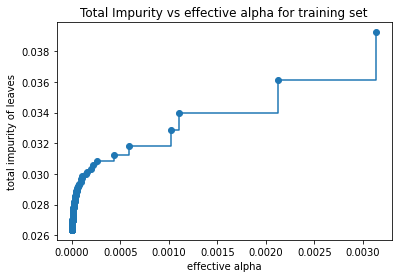

In [36]:
criteria = ["mse", "friedman_mse"] # didn't make a big difference
max_depth = 9 # found to result in best accuracy TODO: test over a range

clf = tree.DecisionTreeRegressor(criterion="mse", max_depth=max_depth)
#     clf = clf.fit(X_train, y_train)

# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# print(cross_val_score(clf, X_train, y_train, cv=cv))


# Following a tutorial on Cost Complexity Pruning https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [37]:
# generating different classifiers having different ccp_alpha values
# WARNING: this takes a very long time to run! Below, ccp_alphas is pruned to cut down on computation time.
# clfs = []
# NUM_CCP_ALPHAS = 5
# ccp_alphas = ccp_alphas[:NUM_CCP_ALPHAS]
# for ccp_alpha in ccp_alphas:   
#     print(f"ccp_alpha: {ccp_alpha}")
#     clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

# search for optimal ccp_alpha (seems to be somewhere in range 10**-4 to 10**-6)
# 0 (99%/-0.6%), 0.0005 (34.3%/33.4%), 0.0000005 (88.3%/5.49%)
for x in range(2,7):
    clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=10**-x)
    clf.fit(X_train, y_train)
    print(f"alpha: {10**-x}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


alpha: 0.01
0.0
-6.145165230697636e-05
alpha: 0.001
0.33014451105222054
0.32280906597284253
alpha: 0.0001
0.3766487014276799
0.3720078295772722
alpha: 1e-05
0.43342332303162534
0.41409083853983186
alpha: 1e-06
0.770628139220939
0.1741188109797961


In [38]:
# search for optimal tree depth (9)
# TODO: plot different depths to demonstrate overfitting as depth increases past 9
for md in range(2,25):
    clf = tree.DecisionTreeRegressor(random_state=0, max_depth=md)
    clf.fit(X_train, y_train)
    print(f"max_depth: {md}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))   

max_depth: 2
0.26377927872881224
0.2556179288920222
max_depth: 3
0.31922515154302245
0.3155007131081793
max_depth: 4
0.3497873907757785
0.3433025982957737
max_depth: 5
0.37353046234509457
0.3662126364260021
max_depth: 6
0.3961770255820789
0.3875785211231938
max_depth: 7
0.41428514843269804
0.40078565473703975
max_depth: 8
0.4303322201197297
0.40837308349584156
max_depth: 9
0.4459233331967858
0.4125337745829928
max_depth: 10
0.46411273921257823
0.40920292377249246
max_depth: 11
0.48619402046365334
0.39984569744523113
max_depth: 12
0.511859551861954
0.3875447596292395
max_depth: 13
0.5411151868706738
0.36815867078762177
max_depth: 14
0.5747024149894395
0.3449164917594665
max_depth: 15
0.6114093144951026
0.3140688975845003
max_depth: 16
0.6487974630369108
0.2804967476003877
max_depth: 17
0.6880890243855318
0.24414371199717766
max_depth: 18
0.7280332210772889
0.20531537604226402
max_depth: 19
0.766202922829292
0.17472155598201278
max_depth: 20
0.8004923173649846
0.13504573620046967
max_dep

In [39]:
# search for optimal max leaf nodes value (maxima somewhere in (256, 324))
for ln in range(2,25):
    max_leaf_nodes = ln**2
    clf = tree.DecisionTreeRegressor(random_state=0, max_leaf_nodes=max_leaf_nodes)
    clf.fit(X_train, y_train)
    print(f"max_leaf_node: {max_leaf_nodes}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

max_leaf_node: 4
0.28523737860475695
0.28021176508181433
max_leaf_node: 9
0.357203848141723
0.3526979405513757
max_leaf_node: 16
0.3785877522877038
0.3736002280191959
max_leaf_node: 25
0.391856046922213
0.38550156590622287
max_leaf_node: 36
0.4015362298723337
0.39386074386211245
max_leaf_node: 49
0.4094787231480488
0.40108637201051067
max_leaf_node: 64
0.4162361283040743
0.4058670929998296
max_leaf_node: 81
0.42201371953216016
0.4098364377815119
max_leaf_node: 100
0.42701245844132785
0.4117779019997858
max_leaf_node: 121
0.4318034127221586
0.413239136988352
max_leaf_node: 144
0.4365377429684124
0.4155562045371731
max_leaf_node: 169
0.4407965190018107
0.4168949675818743
max_leaf_node: 196
0.44475814537216185
0.41806246508429
max_leaf_node: 225
0.44861853174399735
0.4195729494179753
max_leaf_node: 256
0.45241098328868845
0.41971037455992943
max_leaf_node: 289
0.45623990325603125
0.419865428585366
max_leaf_node: 324
0.45998367050816513
0.41935151079471356
max_leaf_node: 361
0.463755542810

In [40]:
# search for optimal min no. leaf samples
for msl in range(1,100,5):
    clf = tree.DecisionTreeRegressor(random_state=0, max_leaf_nodes=298, min_samples_leaf=msl)
    clf.fit(X_train, y_train)
    print(f"min_samples_leaf: {msl}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

min_samples_leaf: 1
0.45726454751599666
0.41981497696174574
min_samples_leaf: 6
0.45720567498381137
0.41954830031871027
min_samples_leaf: 11
0.456774137115566
0.41934168471365174
min_samples_leaf: 16
0.4563659613351674
0.4192713748333612
min_samples_leaf: 21
0.45601821357712335
0.41909985385659587
min_samples_leaf: 26
0.4558099490007268
0.41992681460157966
min_samples_leaf: 31
0.4556055419812487
0.4196298542017143
min_samples_leaf: 36
0.4554633383393696
0.4197111378499373
min_samples_leaf: 41
0.45514768205689926
0.41992783668620104
min_samples_leaf: 46
0.45444946744485837
0.41990151224684935
min_samples_leaf: 51
0.45433432190356426
0.4199647303652225
min_samples_leaf: 56
0.45406456954200225
0.4206130585946174
min_samples_leaf: 61
0.45383928154227104
0.4203109090330569
min_samples_leaf: 66
0.4536150145382203
0.42047695881414926
min_samples_leaf: 71
0.4534072871815972
0.4203216556413619
min_samples_leaf: 76
0.4532507040449977
0.42005680910908105
min_samples_leaf: 81
0.4528543147063998
0.

In [41]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
print(train_scores)
print(test_scores)

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

NameError: name 'clfs' is not defined

In [ ]:
# TODO: perform nested cross-validation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

In [ ]:
# Draw tree
clf.get_depth()
plt.figure(figsize=(50,12))
tree.plot_tree(clf,  fontsize=10, feature_names=headers)
plt.show()